In [1]:
import sys,os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


workpath = os.getcwd()
libpath = workpath + "/libs/"
figpath = workpath + "/figs/"
outpath = workpath + "/out/"
distpath = workpath + "/input/osm-primnet/"
grbpath = workpath + "/gurobi/"
homepath = workpath + "/input/load/121-home-load.csv"


sys.path.append(libpath)
from pyDrawNetworklib import DrawNodes,DrawEdges

print("Imported modules")

Imported modules


In [2]:
def get_home_data(home_filename,shift=6):
    # Extract residence device data
    df_homes = pd.read_csv(home_filename)
    home_rawdata = df_homes.set_index('hid').T.to_dict()
    home_data = {h: {} for h in home_rawdata}
    
    for h in home_rawdata:
        net_load = [1e-3*home_rawdata[h]["hour"+str(i+1)] for i in range(24)]
        home_data[h]["LOAD"] = np.roll(net_load,-shift).tolist()
    return home_data

def GetDistNet(path,code):
    """
    Read the txt file containing the edgelist of the generated synthetic network and
    generates the corresponding networkx graph. The graph has the necessary node and
    edge attributes.
    
    Inputs:
        path: name of the directory
        code: substation ID or list of substation IDs
        
    Output:
        graph: networkx graph
        node attributes of graph:
            cord: longitude,latitude information of each node
            label: 'H' for home, 'T' for transformer, 'R' for road node, 
                    'S' for subs
            voltage: node voltage in pu
        edge attributes of graph:
            label: 'P' for primary, 'S' for secondary, 'E' for feeder lines
            r: resistance of edge
            x: reactance of edge
            geometry: shapely geometry of edge
            geo_length: length of edge in meters
            flow: power flowing in kVA through edge
    """
    if type(code) == list:
        graph = nx.Graph()
        for c in code:
            g = nx.read_gpickle(path+str(c)+'-dist-net.gpickle')
            graph = nx.compose(graph,g)
    else:
        graph = nx.read_gpickle(path+str(code)+'-dist-net.gpickle')
    return graph

In [3]:
s = 6
all_homes = get_home_data(homepath,shift=s)
dist = GetDistNet(distpath,121144)

res = [n for n in dist if dist.nodes[n]['label']=='H']

# Area of interest where EV adoption is studied
xmin = -80.37217
ymin = 37.1993
xmax = xmin + 0.010
ymax = ymin + 0.005
res_interest = [n for n in res if (xmin<=dist.nodes[n]['cord'][0]<=xmax) and (ymin<=dist.nodes[n]['cord'][1]<=ymax)]


In [4]:
np.random.seed(1234)
adoption = 0.1
num_choice = int(adoption * len(res_interest))
ev_home = np.random.choice(res_interest,num_choice,replace=False)

x_int = [dist.nodes[n]['cord'][0] for n in ev_home]
y_int = [dist.nodes[n]['cord'][1] for n in ev_home]

for n in dist:
    if n in ev_home:
        dist.nodes[n]["has_EV"] = True
    else:
        dist.nodes[n]["has_EV"] = False

homes = {}
for h in res:
    homes[h] = all_homes[h]
    if h in ev_home:
        homes[h]["EV"] = {"rating":2.0,"capacity":16.0,"initial":0.5,
                                         "final":0.9,"start":11,"end":23}

# Other input parameters
COST = [1] * 24
prefix = "agentEV"+"home"+str(int(100*adoption))

In [6]:
from pySchedEVChargelib import Home,Utility


P_est = {0:{h:homes[h]["LOAD"] for h in res}}
P_sch = {0:{h:homes[h]["LOAD"] for h in res}}
G = {0:{h:[0]*len(COST) for h in res}}
S = {}
C = {}

iter_max = 20
kappa = 5.0
diff = {}


k = 0
eps = 1
while(k <= iter_max):
    # solve utility level problem to get estimate
    U_obj = Utility(dist,P_est[k],P_sch[k],G[k],kappa=kappa,low=0.9)
    U_obj.solve(grbpath)
    P_est[k+1] = U_obj.g_opt
    
    
    # solve individual agent level problem
    P_sch[k+1] = {}
    S[k+1] = {}
    C[k+1] = {}
    for h in res:
        H_obj = Home(COST,homes[h],P_est[k][h],P_sch[k][h],G[k][h],kappa=kappa)
        H_obj.solve(grbpath)
        P_sch[k+1][h] = H_obj.g_opt
        S[k+1][h] = H_obj.p_opt
        C[k+1][h] = H_obj.s_opt
        
    
    
    # update dual variables
    G[k+1] = {}
    diff[k+1] = {}
    for h in res:
        check = [(P_est[k+1][h][t] - P_sch[k+1][h][t]) for t in range(len(COST))]
        G[k+1][h] = [G[k][h][t] + (kappa/2) * check[t] for t in range(len(COST))]
        diff[k+1][h] = np.linalg.norm(np.array(check))/len(COST)
    
    
    
    k = k + 1
    #print("Iteration: ",k)


# Plot the convergence
xtix = range(1,k+1)
fig4 = plt.figure(figsize=(20,16))
ax4 = fig4.add_subplot(1,1,1)
for h in ev_home:
    ax4.plot(xtix,[diff[k][h] for k in xtix],
             label="Home "+str(h))
ax4.set_ylabel("Difference",fontsize=25)
ax4.set_xlabel("Iterations",fontsize=25)
ax4.legend(loc='best',ncol=1,prop={'size': 25})
ax4.set_xticks(list(range(0,21,5)))
ax4.tick_params(axis='y', labelsize=25)
ax4.tick_params(axis='x', labelsize=25)
fig4.savefig("{}{}.png".format(figpath,prefix+'-convergence'),
              bbox_inches='tight')

KeyboardInterrupt: 

In [ ]:
from pySchedLoadlib import compute_Rmat
R = compute_Rmat(dist)
nodelist = [n for n in dist if dist.nodes[n]['label']!='S']


P = np.zeros(shape=(len(nodelist),len(COST)))
Z = np.ones(shape=(len(nodelist),len(COST)))
for i,n in enumerate(nodelist):
    if n in res:
        P[i,:] = np.array(P_sch[k][n])

V = np.sqrt(Z - R@P)
volt = {h:V[i,:].tolist() for i,h in enumerate(nodelist) if h in nodelist}
volt_data = [[volt[n][t] for n in nodelist] for t in range(len(COST))]

fig5 = plt.figure(figsize=(20,16))
ax5 = fig5.add_subplot(1,1,1)
ax5.boxplot(volt_data)

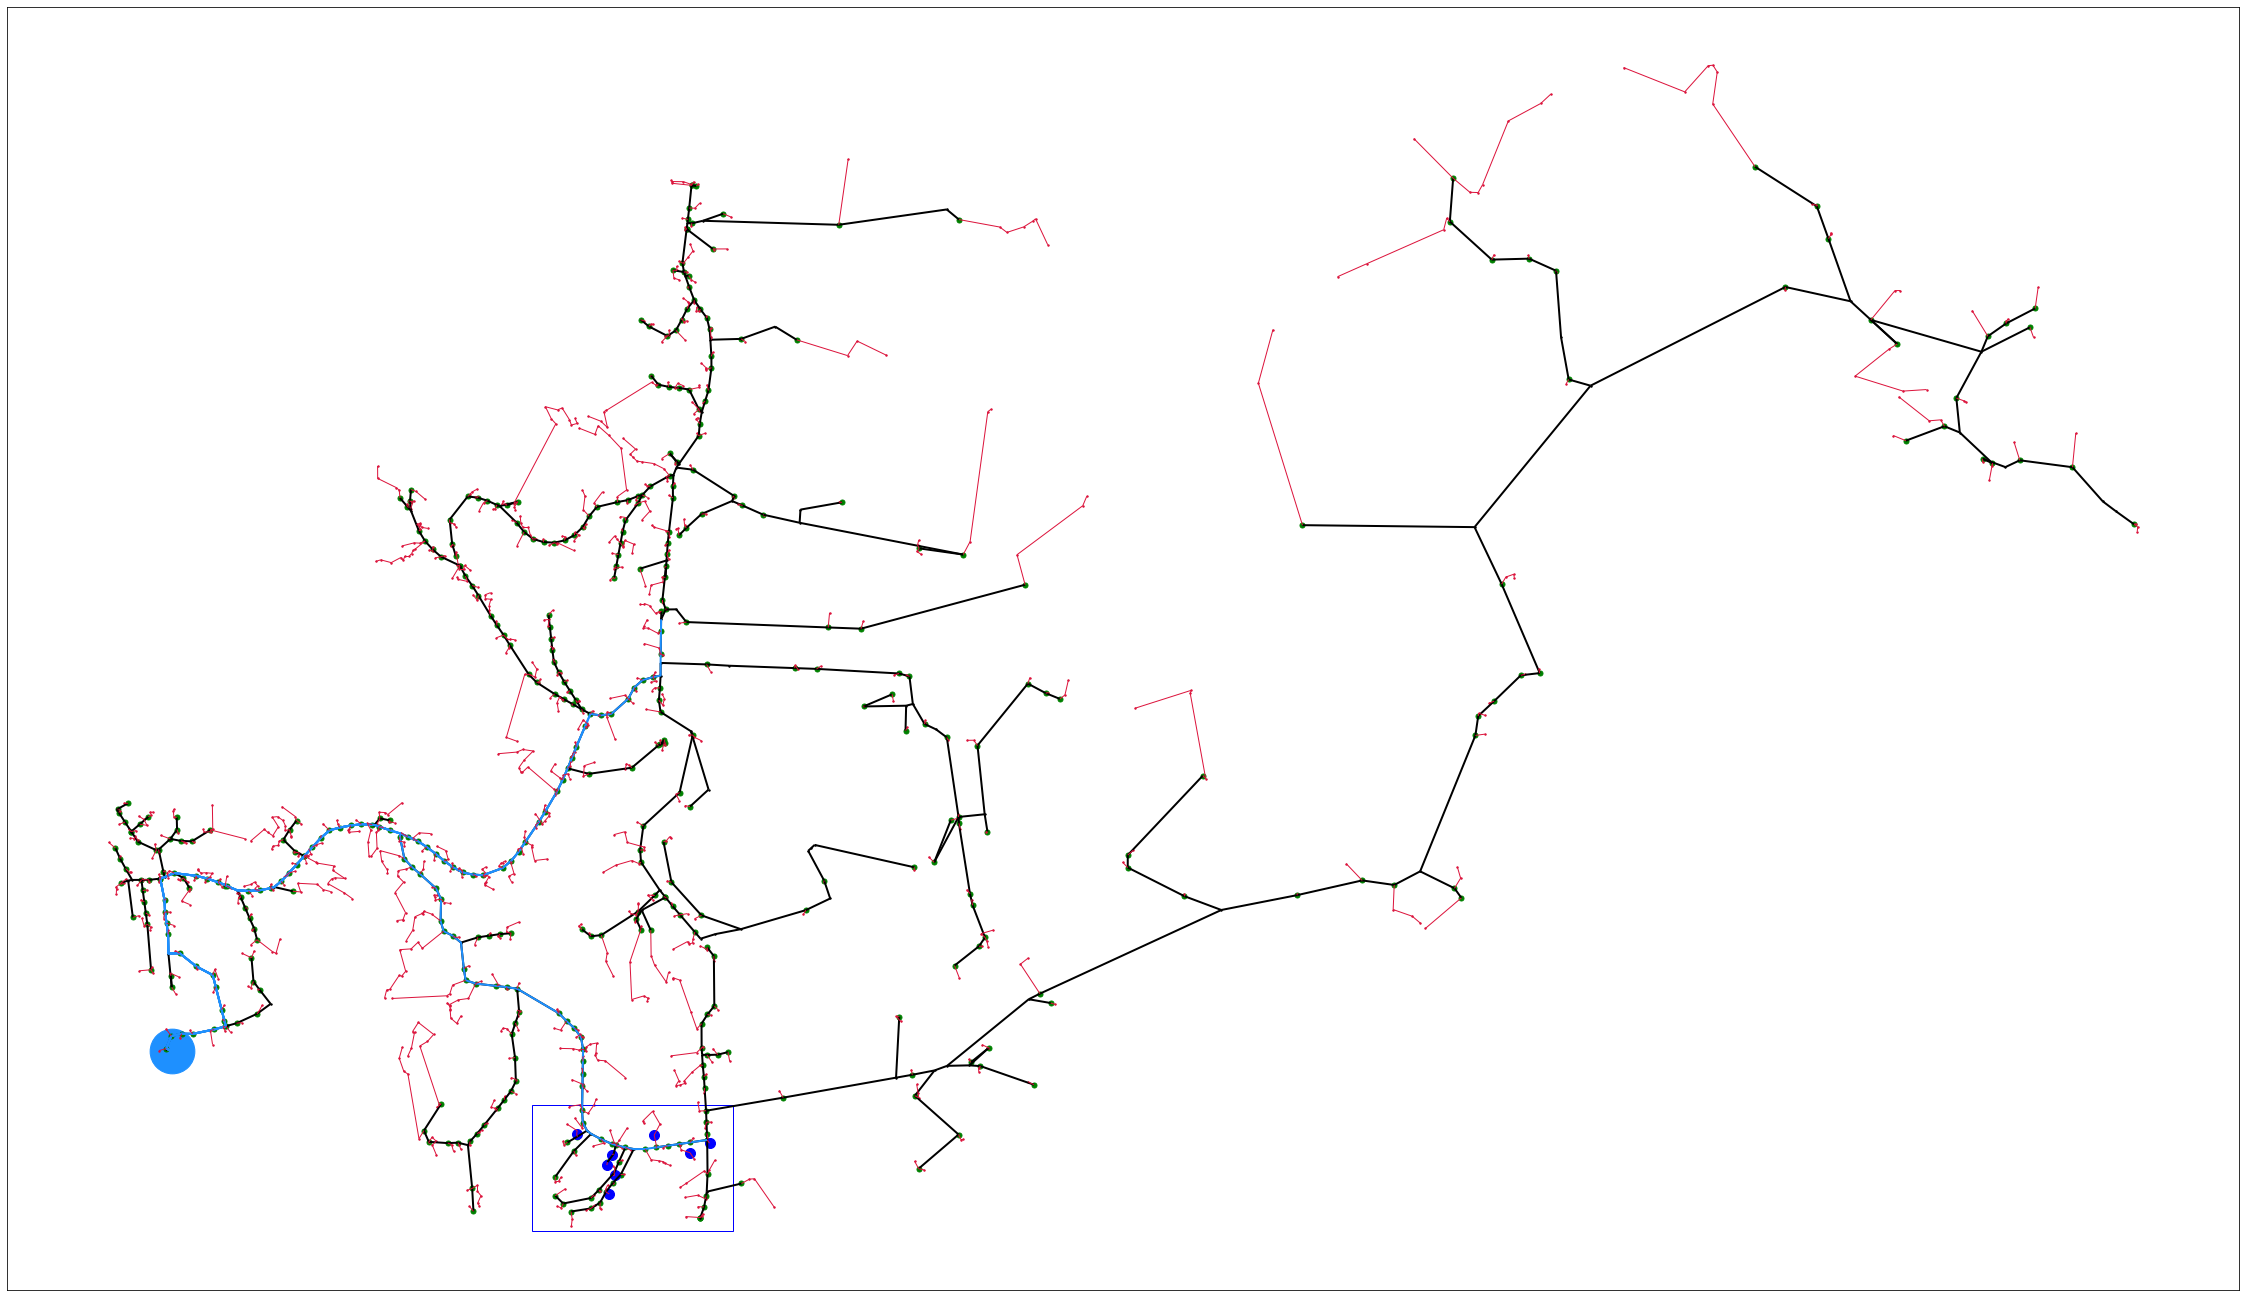

In [5]:
def plot_network(ax,net,path=None,with_secnet=False):
    """
    """
    # Draw nodes
    DrawNodes(net,ax,label='S',color='dodgerblue',size=2000)
    DrawNodes(net,ax,label='T',color='green',size=25)
    DrawNodes(net,ax,label='R',color='black',size=2.0)
    if with_secnet: DrawNodes(net,ax,label='H',color='crimson',size=2.0)
    # Draw edges
    DrawEdges(net,ax,label='P',color='black',width=2.0)
    DrawEdges(net,ax,label='E',color='dodgerblue',width=2.0)
    if with_secnet: DrawEdges(net,ax,label='S',color='crimson',width=1.0)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    if path != None: 
        fig.savefig("{}{}.png".format(path,'-51121-dist'),bbox_inches='tight')
    return ax

fig = plt.figure(figsize=(40,40), dpi=72)
ax = fig.add_subplot(111)
ax = plot_network(ax,dist,with_secnet=True)

# Create a Rectangle patch
rect = patches.Rectangle((-80.37217, 37.1993), 0.01, 0.005, linewidth=1, edgecolor='blue', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
ax.scatter(x_int,y_int,s=100.0,c='b')


In [7]:
511210207001728

True

In [58]:
np.roll(range(24),-6)

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23,  0,  1,  2,  3,  4,  5])